## Particle Swarm Optimization (PSO)
PSO는 SVM 매개변수 조정이나 퍼지 클러스터링에서 사용되며, 빠르고 안정적인 성능을 보임

## 단일 목적
### 목적 1. price 최소화/최대화

In [2]:
import pandas as pd
import numpy as np
from pyswarm import pso
from joblib import load

# 1. Surrogate 모델 불러오기 (pkl 파일)
surrogate_model = load('/data/ephemeral/home/Sojeong/level4-cv-finalproject-hackathon-cv-02-lv3/Sojeong/surrogate/autosklearn_model.pkl')

# # 최적 모델 가져오기
# models_with_weights = surrogate_model.get_models_with_weights()
# best_model = models_with_weights[0][1]  # 최적 모델만 추출 (파이프라인 포함)

# 2. 데이터셋 불러오기
df = pd.read_csv("/data/ephemeral/home/Sojeong/level4-cv-finalproject-hackathon-cv-02-lv3/Sojeong/surrogate/melb_split.csv")
data = df.drop(['Price', 'Split', 'Address', 'BuildingArea', 'YearBuilt'], axis=1)  # 제외한 데이터

# 3. 목표 함수 정의
def objective_function(x):
    """
    PSO의 목적 함수
    x: 최적화 대상 변수 리스트 (['Distance', 'Landsize'])
    return: 목표값과 예측값(Predicted) 간의 차이
    """
    #target_price = 10000000  # 최적화 목표값
    
    # Distance와 Landsize 열을 업데이트
    data_copy = data.copy()
    data_copy["Distance"] = x[0]
    data_copy["Landsize"] = x[1]
    print(x[0], x[1])

    # Price 열 제거 (모델 학습 시 타겟 열)
    input_features = data_copy

    # Surrogate 모델로 예측 수행
    predicted_prices = surrogate_model.predict(input_features)

    # 모든 예측 값과 목표값의 평균 차이 반환
    #return np.mean(np.abs(predicted_prices - target_price)) # y_hat - y(Price값이 아니라 우리가 원하는 목표값)
    #return np.mean(predicted_prices)  # Price값을 최소화
    return -np.mean(predicted_prices)  # Price값을 최대화

# 4. PSO 최적화
# 각 변수의 범위 설정
lb = [data['Distance'].min(), data['Landsize'].min()]  # 'Distance', 'Landsize' 최소값
#ub = [38, 4583]  # 'Distance', 'Landsize' 최대값
ub = [data['Distance'].max(), data['Landsize'].max()]  # 'Distance', 'Landsize' 최대값

# PSO 실행
best_x, best_f = pso(objective_function, lb, ub, swarmsize=30, maxiter=25, debug=True)

# 결과 출력
print("최적화된 특성 값 ('Distance', 'Landsize'):", best_x)
print("목표값:", best_f)

No constraints given.
35.666393663998385 361459.5807910228
31.895850830737643 294594.68161790457
43.403048196887895 284532.4783513463
7.31662448604999 15204.230609698836
37.83081337215086 79554.9190957844
24.149170965569585 122338.27976089754
21.42656899022434 206903.31853774676
33.89742970880121 146372.59322009332
8.27616577880277 83178.06457349929
25.406324706002987 83957.34982115323
3.2091555074353155 3354.13514741421
39.55800839050361 396976.68210150587
47.62452650966691 75587.92621946192
36.9118124033297 26840.852735507415
32.51364829989228 86084.24637457075
41.34442718855951 410142.9811263228
30.67545326145394 387700.6213737934
40.09945334285167 353502.78072104254
8.853235523026886 283083.7088490896
8.099057443469 309312.9154445344
9.762844833523726 243999.81624469312
3.9907585928111176 101741.90472890156
14.117822081733392 240607.28097176715
40.848563898167086 134821.83891839095
41.280119379107376 355648.0025271241
14.911945814176102 115.44766501618564
41.76130597314429 48113.54

In [58]:
# 최적화된 결과를 Surrogate 모델로 확인
# Distance와 Landsize 열을 업데이트
data_copy1 = data.copy()
data_copy1["Distance"] = best_x[0]
data_copy1["Landsize"] = best_x[1]

# Price 열 제거 (모델 학습 시 타겟 열)
input_features1 = data_copy1#.drop(columns=["Price"])

# Surrogate 모델로 예측 수행
final_predicted_price = surrogate_model.predict(input_features1)
print(final_predicted_price.shape)    
print("최적화된 Predicted 값:", final_predicted_price)

(13580,)
최적화된 Predicted 값: [1788829.30078125  894908.484375   1109779.00390625 ...  955726.54492188
 1457456.4765625  1029908.5703125 ]


In [59]:
best_x

array([  10.        , 1486.99997359])

## 2. multi-objective 
### 목적 1. Price 최소화/최대화
### 목적 2.  Distance 최소화

- 방법 1 - 가중합
- 방법 2 - 파레토 기반

### 방법 1 - 가중합
(가중치를 내가 직접 줘야함)

In [64]:
# 다중 목표 함수 정의
def multi_objective_function(x, w1=0.7, w2=0.3):
    """
    PSO의 다중 목표 함수
    x: 최적화 대상 변수 리스트 (['Distance', 'Landsize'])
    w1: 첫 번째 목표의 가중치 (default: 0.7)
    w2: 두 번째 목표의 가중치 (default: 0.3)
    return: 가중합으로 변환된 단일 목표 값
    """
    # Distance와 Landsize 열을 업데이트
    data_copy = data.copy()
    data_copy["Distance"] = x[0]
    data_copy["Landsize"] = x[1]

    # Surrogate 모델로 예측 수행
    input_features = data_copy
    predicted_prices = surrogate_model.predict(input_features)

    # 목표 1: Price와 목표값 차이
    objective1 = np.mean(predicted_prices) # 최소화
    #objective1 = -np.mean(predicted_prices) # 최대화

    # 목표 2: Distance 최소화
    objective2 = x[0]

    # 가중합 계산
    return w1 * objective1 + w2 * objective2

# PSO 실행
# lb와 ub는 'Distance'와 'Landsize'의 탐색 범위
best_x, best_f = pso(multi_objective_function, lb, ub, args=(0.7, 0.3), swarmsize=30, maxiter=5, debug=True)

# 결과 출력
print("최적화된 특성 값 ('Distance', 'Landsize'):", best_x)
print("가중합된 다중 목표 값:", best_f)

No constraints given.
New best for swarm at iteration 1: [21.64673097  0.        ] 462483.1477213193
New best for swarm at iteration 1: [25.07367246  0.        ] 429005.53228821576
New best for swarm at iteration 1: [32.80859153  0.        ] 391873.71813271515
Best after iteration 1: [32.80859153  0.        ] 391873.71813271515
New best for swarm at iteration 2: [38.  0.] 373982.56353387266
Best after iteration 2: [38.  0.] 373982.56353387266
Best after iteration 3: [38.  0.] 373982.56353387266
Best after iteration 4: [38.  0.] 373982.56353387266
Best after iteration 5: [38.  0.] 373982.56353387266
Stopping search: maximum iterations reached --> 5
최적화된 특성 값 ('Distance', 'Landsize'): [38.  0.]
가중합된 다중 목표 값: 373982.56353387266


### 방법 2. 파라토 기반

In [1]:
# # 파레토 우월성 비교 함수
# def is_dominated(f1, f2):
#     return all(f1 <= f2) and any(f1 < f2)  # f1이 f2를 우월하면 True 반환

# # 다중 목표 PSO 함수 정의
# def pso_pareto(funcs, lb, ub, swarmsize=30, maxiter=5):
#     """
#     다중 목표 PSO (파레토 최적화 기반)
#     funcs: 다중 목표 함수 리스트 [func1, func2, ...]
#     lb: 하한 리스트
#     ub: 상한 리스트
#     """
#     S = swarmsize
#     D = len(lb)
#     x = np.random.rand(S, D) * (ub - lb) + lb  # 초기 위치
#     v = np.zeros_like(x)
#     personal_best = x.copy()
#     personal_fitness = [np.inf] * S
#     global_pareto = []

#     for iteration in range(maxiter):
#         fitness = np.array([[func(xi) for func in funcs] for xi in x])  # 다중 목표 값 계산

#         # 개인 최적 위치 갱신
#         for i in range(S):
#             if is_dominated(fitness[i], personal_fitness[i]):
#                 personal_best[i] = x[i]
#                 personal_fitness[i] = fitness[i]

#         # 전역 파레토 최적 집합 갱신
#         for f, xi in zip(fitness, x):
#             dominated = False
#             for fg in global_pareto:
#                 if is_dominated(f, fg):
#                     dominated = True
#                     break
#             if not dominated:
#                 global_pareto.append(f)

#         # 입자 속도와 위치 업데이트
#         rp = np.random.rand(S, D)
#         rg = np.random.rand(S, D)
#         v = 0.5 * v + 0.5 * rp * (personal_best - x)
#         x = x + v

#     return global_pareto


# # 다중 목표 함수 정의
# def objective1(x):
#     data_copy = data.copy()
#     data_copy["Distance"] = x[0]
#     data_copy["Landsize"] = x[1]
#     predicted_prices = surrogate_model.predict(data_copy)
#     return np.mean(predicted_prices)  # Price 최소화

# def objective2(x):
#     return x[0]  # Distance 최소화

# # 실행
# pareto_front = pso_pareto([objective1, objective2], lb, ub)

# # 결과 출력
# print("파레토 최적 집합:", pareto_front)

# Optimizer 라이브러리

In [3]:
!pip install opytimizer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 13.0 MB/s eta 0:00:00a 0:00:01


In [2]:
# import numpy as np

# from opytimizer import Opytimizer
# from opytimizer.core import Function
# from opytimizer.optimizers.swarm import PSO
# from opytimizer.spaces import SearchSpace

# import pandas as pd
# import numpy as np
# from pyswarm import pso
# from joblib import load

# # 1. Surrogate 모델 불러오기 (pkl 파일)
# surrogate_model = load('/data/ephemeral/home/Sojeong/level4-cv-finalproject-hackathon-cv-02-lv3/Sojeong/surrogate/autosklearn_model.pkl')

# # 2. 데이터셋 불러오기
# df = pd.read_csv("/data/ephemeral/home/Sojeong/level4-cv-finalproject-hackathon-cv-02-lv3/Sojeong/surrogate/melb_split.csv")
# data = df.drop(['Price', 'Split', 'Address', 'BuildingArea', 'YearBuilt'], axis=1)  # 제외한 데이터

# # 3. 목표 함수 정의
# def sphere(x):
#     # Distance와 Landsize 열을 업데이트
#     data_copy = data.copy()
#     data_copy["Distance"] = x[0]
#     data_copy["Landsize"] = x[1]
#     print(x[0], x[1])

#     # Price 열 제거 (모델 학습 시 타겟 열)
#     input_features = data_copy

#     # Surrogate 모델로 예측 수행
#     predicted_prices = surrogate_model.predict(input_features)

#     # 모든 예측 값과 목표값의 평균 차이 반환
#     return -np.mean(predicted_prices)  # Price값을 최대화

# n_agents = 20
# n_variables = 2
# lower_bound = [data['Distance'].min(), data['Landsize'].min()]  # 'Distance', 'Landsize' 최소값
# upper_bound = [data['Distance'].max(), data['Landsize'].max()]  # 'Distance', 'Landsize' 최대값

# space = SearchSpace(n_agents, n_variables, lower_bound, upper_bound)
# optimizer = PSO()
# function = Function(sphere)

# opt = Opytimizer(space, optimizer, function)
# opt.start(n_iterations=1000)

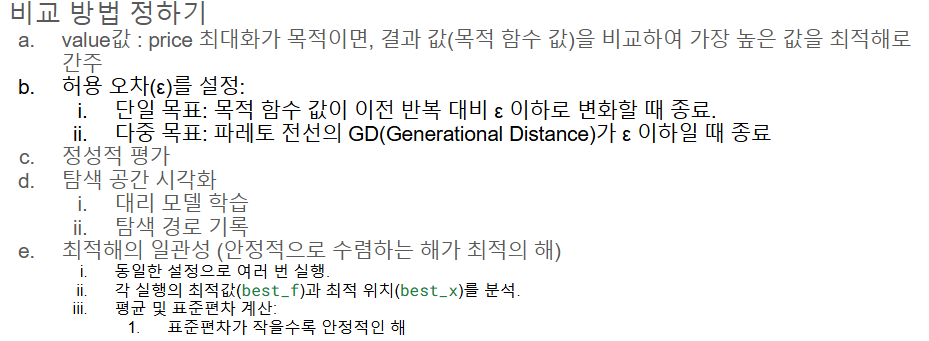